# Predicción precio de acciones con series de tiempo:

Este Notebook contiene un ejercicio de predicción de series de tiempo utilizando:
- Pruebas de estacionalidad
- Creación de modelos con regresión lineal y de Holt-Winters
- Uso de la librería de Yahoo Finanzas para obtener el precio de las acciones

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import yfinance as yf

# Descargar datos históricos con la librería de Yahoo Finance
# Para evitar que el modelo cambie cuando se ejecute el código, definimos las fechas
data = yf.download("CIB", start="2018-09-01", end="2023-09-01", interval="1wk")
data = pd.DataFrame(data)
data.head(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-03,43.029999,43.139999,41.139999,41.369999,32.461807,1170600
2018-09-10,41.400002,41.570000,39.130001,40.160000,31.512354,2504000


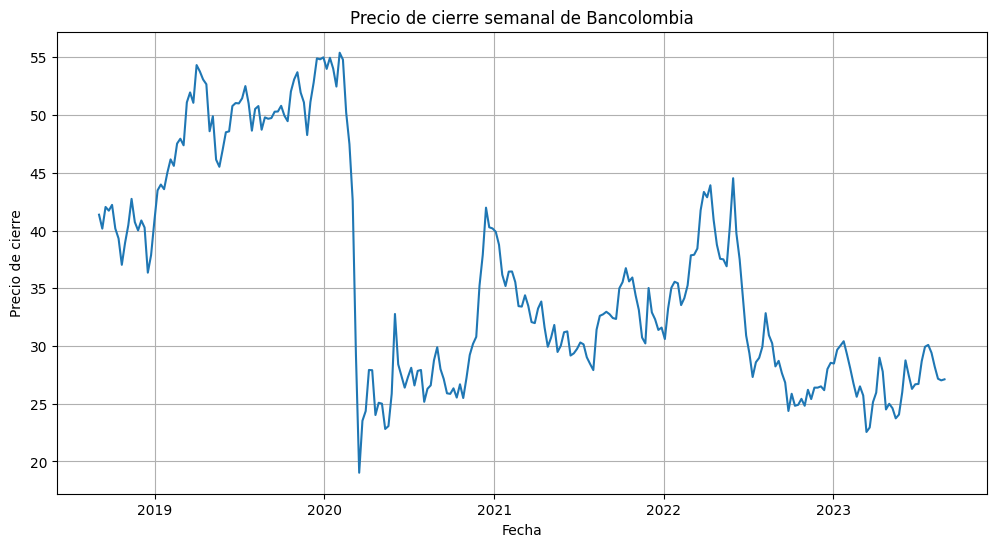

In [ ]:
# Visualizar los datos de cierre semanales
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.title('Precio de cierre semanal de Bancolombia')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.grid(True)  # Agregar una cuadrícula para facilitar la lectura de los valores
plt.show()


## Prueba de estacionalidad de Dickey-Fuller Aumentada (ADF) para determinar los modelos de series de tiempo que se pueden usar. (Si p es menor a 0.05, se rechaza la hipótesis nula) Es decir, que hay estacionalidad. Si no se rechaza la hipótesis nula, quiere decir que no es estacional

In [ ]:
# Aplicar la prueba de Dickey-Fuller Aumentada
result = adfuller(data['Close'])

# Imprimir los resultados
print('Estadística de prueba ADF:', result[0])
print('Valor p:', result[1])
print('Valores críticos:', result[4])
print('Resultados de la prueba:')
if result[1] <= 0.05:
    print('La serie es estacionaria (rechazamos la hipótesis nula)')
else:
    print('La serie no es estacionaria (no rechazamos la hipótesis nula). Es decir, no hay estacionalidad.')


Estadística de prueba ADF: -2.1722703873573996
Valor p: 0.21646316960053452
Valores críticos: {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}
Resultados de la prueba:
La serie no es estacionaria (no rechazamos la hipótesis nula). Es decir, no hay estacionalidad.


## Se escogen los modelos de regresión lineal y de Holt-Winters para compararlos, ya que no requieren que exista estacionalidad.

In [ ]:
def train_and_forecast(data):
    # Seleccionar la columna 'Close' como variable objetivo
    target_column = 'Close'
    y = data[target_column]

    # Separar los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=[target_column]), y, test_size=0.2, shuffle=False)

    # Crear y entrenar un modelo de regresión lineal
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba para Regresión Lineal
    y_pred_lr = model_lr.predict(X_test)

    # Calcular métricas de efectividad para Regresión Lineal
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    mse_lr = mean_squared_error(y_test, y_pred_lr)

    # Crear y entrenar un modelo de Holt-Winters
    model_hw = ExponentialSmoothing(y_train, trend="add", seasonal="add", seasonal_periods=12)
    model_hw_fit = model_hw.fit()

    # Realizar predicciones en el conjunto de prueba para Holt-Winters
    y_pred_hw = model_hw_fit.forecast(len(X_test))

    # Calcular métricas de efectividad para Holt-Winters
    mae_hw = mean_absolute_error(y_test, y_pred_hw)
    mse_hw = mean_squared_error(y_test, y_pred_hw)

    # Generar proyecciones para las siguientes 4 semanas con Regresión Lineal
    X_future_lr = X_test.tail(4)
    y_future_pred_lr = model_lr.predict(X_future_lr)

    # Generar proyecciones para las siguientes 4 semanas con Holt-Winters
    last_date = data.index[-1]
    date_range = pd.date_range(start=last_date, periods=4 + 1, closed='right')
    forecast_values_hw = model_hw_fit.forecast(steps=4)

    # Crear un DataFrame con las proyecciones
    forecast_df_lr = pd.DataFrame({'Fecha': date_range, 'Proyección_LR': y_future_pred_lr})
    forecast_df_hw = pd.DataFrame({'Fecha': date_range, 'Proyección_HW': forecast_values_hw})

    # Devolver las métricas y las proyecciones
    metrics = {
        'MAE_LR': mae_lr,
        'MSE_LR': mse_lr,
        'MAE_HW': mae_hw,
        'MSE_HW': mse_hw
    }

    return metrics, forecast_df_lr, forecast_df_hw

In [ ]:
train_and_forecast(data)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
<ipython-input-4-10052805532e>:37: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  date_range = pd.date_range(start=last_date, periods=4 + 1, closed='right')


({'MAE_LR': 0.7905296272147826,
  'MSE_LR': 0.8352398554756963,
  'MAE_HW': 2.143823218656637,
  'MSE_HW': 6.500581668716877},
        Fecha  Proyección_LR
 0 2023-08-29      29.331935
 1 2023-08-30      28.317243
 2 2023-08-31      28.431050
 3 2023-09-01      28.365544,
                 Fecha  Proyección_HW
 2022-08-29 2023-08-29      29.367655
 2022-09-05 2023-08-30      29.597038
 2022-09-12 2023-08-31      29.876473
 2022-09-19 2023-09-01      29.545852)

In [ ]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-03,43.029999,43.139999,41.139999,41.369999,32.461807,1170600
2018-09-10,41.400002,41.570000,39.130001,40.160000,31.512354,2504000
2018-09-17,40.230000,42.779999,40.230000,42.040001,32.987526,1447600
2018-09-24,42.070000,42.389999,40.779999,41.720001,32.736435,1117200
2018-10-01,41.820000,42.959999,41.639999,42.220001,33.394024,1215800
...,...,...,...,...,...,...
2023-07-31,30.170000,30.629999,28.270000,29.410000,29.410000,1516200
2023-08-07,29.430000,29.770000,27.139999,28.200001,28.200001,1915800
2023-08-14,28.059999,28.070000,26.680000,27.160000,27.160000,1448400


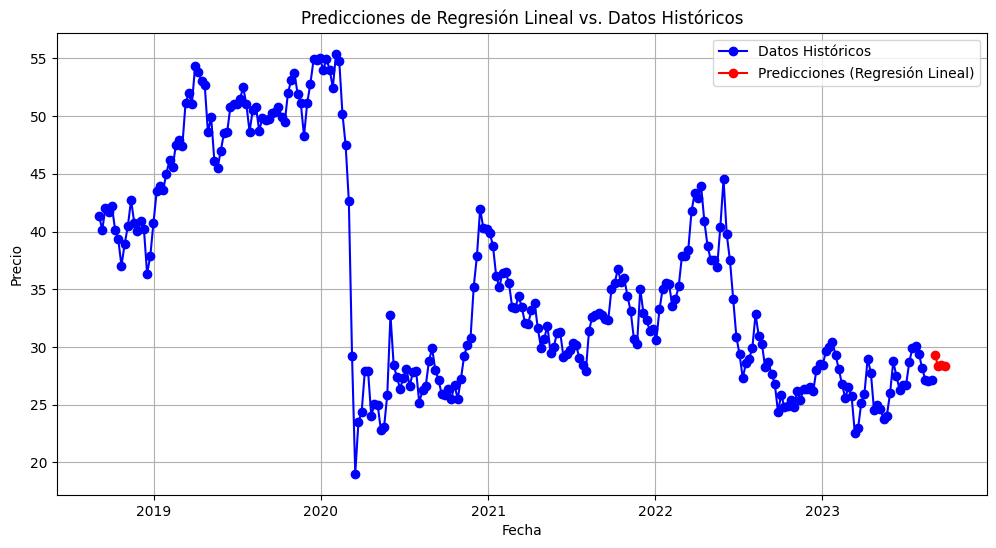

In [ ]:

# Seleccionar la columna 'Close' como variable objetivo
target_column = 'Close'
y = data[target_column]

# Separar los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=[target_column]), y, test_size=0.2, shuffle=False)

# Crear y entrenar un modelo de regresión lineal
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba para Regresión Lineal
y_pred_lr = model_lr.predict(X_test)

# Calcular métricas de efectividad para Regresión Lineal
mae_lr = mean_absolute_error(y_test, y_pred_lr)

# Generar proyecciones para las siguientes 4 semanas con Regresión Lineal
X_future_lr = X_test.tail(4)
y_future_pred_lr = model_lr.predict(X_future_lr)

# Crear un DataFrame con las fechas para el gráfico
dates = data.index
dates_future = pd.date_range(start=dates[-1], periods=5, freq='W-MON')  # Frecuencia semanal, iniciando en lunes

# Crear una figura de matplotlib para el gráfico
plt.figure(figsize=(12, 6))

# Graficar los datos históricos
plt.plot(dates, y, label='Datos Históricos', color='blue', marker='o')

# Graficar las predicciones para las próximas 4 semanas
plt.plot(dates_future[1:], y_future_pred_lr, label='Predicciones (Regresión Lineal)', color='red', marker='o')

# Etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Predicciones de Regresión Lineal vs. Datos Históricos')

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()


In [ ]:
# Crear un DataFrame con las fechas para las próximas 4 semanas
dates_future = pd.date_range(start=dates[-1], periods=5, freq='W-MON')[1:]

# Crear un DataFrame con las predicciones de Regresión Lineal
predictions_lr = pd.DataFrame({'Fecha': dates_future, 'Predicción_LR': y_future_pred_lr})

# Mostrar el DataFrame con las predicciones
print(predictions_lr)


       Fecha  Predicción_LR
0 2023-09-04      29.331935
1 2023-09-11      28.317243
2 2023-09-18      28.431050
3 2023-09-25      28.365544


# Definición del camino para validar los resultados:
## Se creó una función que descarga los datos y los compara contra el modelo:

In [ ]:
def update_and_compare(model):
    # Definir la fecha de inicio como el viernes 01 de septiembre
    start_date = "2023-09-01"

    # Obtener la fecha actual
    current_date = pd.Timestamp.today()

    # Verificar si la fecha actual es posterior al viernes 01 de septiembre de manera semanal
    if current_date.day_name() == "Friday" and current_date > pd.Timestamp(start_date):
        # Descargar los datos más recientes (diarios) desde el viernes 01 de septiembre
        new_data = yf.download("CIB", start=start_date, end=current_date, interval="1d")

        # Preprocesar los datos (asegúrate de aplicar el mismo preprocesamiento que usaste para entrenar el modelo)
        # ...

        # Realizar predicciones con el modelo
        y_pred = model.predict(new_data.drop(columns=['Close']))

        # Calcular métricas de efectividad (MAE y MSE) si tienes datos reales para comparar
        # ...

        return new_data, y_pred

    else:
        print("Los datos no cumplen con las condiciones para actualización.")
        return None, None

In [ ]:
# Llama a la función update_and_compare con tu modelo de Regresión Lineal
updated_data, predictions = update_and_compare(model_lr)

# Verifica si los datos y predicciones se han actualizado correctamente
if updated_data is not None and predictions is not None:
    # Aquí puedes realizar comparaciones y análisis con los datos actualizados y las predicciones
    print("Datos Actualizados:")
    print(updated_data.tail())  # Muestra los datos más recientes
    print("\nPredicciones:")
    print(predictions)  # Muestra las predicciones
else:
    print("No se han realizado actualizaciones.")


Los datos no cumplen con las condiciones para actualización.
No se han realizado actualizaciones.
